<a href="https://colab.research.google.com/github/ypeng22/DLFinal/blob/main/DL_proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Setup

In [2]:
!pip install plantcv
!pip install c3d


     |████████████████████████████████| 225kB 8.6MB/s 
     |████████████████████████████████| 48.6MB 122kB/s 
     |████████████████████████████████| 706kB 26.2MB/s 
ERROR: distributed 2021.4.1 has requirement dask>=2021.03.0, but you'll have dask 2.12.0 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
ERROR: dask-jobqueue 0.7.2 has requirement dask>=2.19, but you'll have dask 2.12.0 which is incompatible.
  Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Successfully uninstalled opencv-python-4.1.2.30
  Found existing installation: cloudpickle 1.3.0
    Uninstalling cloudpickle-1.3.0:
      Successfully uninstalled cloudpickle-1.3.0
  Found existing installation: distributed 1.25.3
    Uninstalling distributed-1.25.3:
      Successfully uninstalled distributed-1.25.3


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import c3d
import cv2
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
import os
from plantcv import plantcv as pcv
from scipy import ndimage
import torchvision
import time

In [5]:
## Mount Google Drive Data (If using Google Colaboratory)
try:
    from google.colab import drive
    drive.mount('/content/gdrive')
except:
    print("Mounting Failed.")


Mounted at /content/gdrive


In [7]:
data_dir = "/content/gdrive/MyDrive/BerkeleyMHAD/"
subjects = ['S01', 'S02', 'S03', 'S04', 'S05','S06', 'S07', 'S08', 'S09', 'S10', 'S11', 'S12']
actions = ['A01', 'A02', 'A03', 'A04', 'A05','A06', 'A07', 'A08', 'A09', 'A10', 'A11']
reps = ['R01', 'R02', 'R03', 'R04', 'R05']

#LSTM on Skeleton Data

In [8]:
################ Dataloader for Berkeley Mocap Optical Data #################

def c3d2array(loc: str, frame_rate):
    """
    Takes in the file location of the c3d file as a string and returns a 
    numpy array w/ the sensor data
    Array Shape: Num_frames x 43 x 3 
      43 corresponds to the number of nodes on the person
      3 corresponds to spatial coordinates of the nodes
    """
    point_series = []
    reader = c3d.Reader(open(loc, 'rb'))
    for i, points, analog in reader.read_frames():     
        if i % frame_rate == 0: ## Set Frame Rate to approximately 22 Hz instead of 480 Hz
            point_series.append(points[:, 0:3])
    point_series = np.array(point_series)
    return point_series

class BerkeleyMocapOpticalDataset(Dataset):
    """Berkeley Mocap Optical Dataset."""

    def __init__(self, root_dir, train, frame_rate, transform=None):
        """
        Args:
            root_dir (string): Directory with all the data
            train (string): has to be one of "train", "test", or "val"
            frame_rate (integer): In Hz 
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.root_dir = root_dir
        if train == 'train':
            self.list_c3d = [file for file in os.listdir(root_dir) if (os.path.isfile(os.path.join(root_dir, file)) and file[-1] != 't' and int(file[5:7]) < 9) ] #list of all the c3d file names for the first 8 subjects
        elif train == 'test':
            self.list_c3d = [file for file in os.listdir(root_dir) if (os.path.isfile(os.path.join(root_dir, file)) and file[-1] != 't' and int(file[5:7]) > 8 and int(file[5:7]) < 12) ] #list of all the c3d file names for the subjects 9, 10, 11
        else:
            self.list_c3d = [file for file in os.listdir(root_dir) if (os.path.isfile(os.path.join(root_dir, file)) and file[-1] != 't' and int(file[5:7]) == 12) ] #list of all the c3d file names for the subject 12
        self.frame_rate = frame_rate
        self.transform = transform
        for idx, item in enumerate(self.list_c3d): 
            item_loc = os.path.join(self.root_dir, item)
            self.list_c3d[idx] = (c3d2array(item_loc, self.frame_rate), item)

    def __len__(self):
        return len(self.list_c3d)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        sample = self.list_c3d[idx][0]
        c3d_file_location = os.path.join(self.root_dir,
                                self.list_c3d[idx][1])
        label_location = c3d_file_location.find('_a')
        if label_location == -1: # FUCK T-POSE
            label = 12
        else: 
            label = int(c3d_file_location[label_location+2:label_location+4])
        if self.transform:
            sample = self.transform(sample)
        # Flatten Samples 
        sample = torch.transpose(sample, 0, 1)
        sample = torch.flatten(sample, 1, 2)
        sample = torch.unsqueeze(sample, 0)
        sample = sample.float()
        # I think labels should go from 0 through 11 since we are using argmax later for loss/accuracy
        return sample, label - 1


############### Compute Mean and SD across the dataset #############
## If you wish to uncomment the code below and rerun it, you might have to comment out the three lines which cflatten the sample in the class above
'''transform = None
root_dir = data_dir + 'Mocap/OpticalData'
frame_rate = 1

dataloader = BerkeleyMocapOpticalDataset(root_dir, "train", 1)
x_list = []
y_list = []
z_list = []

for sample,_ in dataloader:
  x_list.append(np.ndarray.flatten(sample[:,:,0]))
  y_list.append(np.ndarray.flatten(sample[:,:,1]))
  z_list.append(np.ndarray.flatten(sample[:,:,2]))

x_list = np.concatenate(np.array(x_list))
y_list = np.concatenate(np.array(y_list))
z_list = np.concatenate(np.array(z_list))
x_mean = np.mean(x_list)
x_sd = np.std(x_list)
y_mean = np.mean(y_list)
y_sd = np.std(y_list)
z_mean = np.mean(z_list)
z_sd = np.std(z_list)
print([x_mean, y_mean, z_mean, x_sd, y_sd, z_sd])'''

############### Define a transform with mean, std, and tensor ############
## So we don't need to rerun for the mean and standard deviations every time
x_mean, x_sd, y_mean, y_sd, z_mean, z_sd = -455.09898495222086, 245.84348947768748, 148.47916727630624, 183.09031602408763, 814.4396506806088, 538.2824468734605
transform = torchvision.transforms.Compose([
  torchvision.transforms.ToTensor(),
  torchvision.transforms.Normalize((x_mean, y_mean, z_mean), (x_sd, y_sd, z_sd)),
])


############# Final Dataloaders ####################
root_dir = data_dir + 'Mocap/OpticalData'
frame_rate = 22
val_dataloader = BerkeleyMocapOpticalDataset(root_dir, "val", frame_rate, transform=transform)
train_dataloader = BerkeleyMocapOpticalDataset(root_dir, "train", frame_rate, transform=transform)
test_dataloader = BerkeleyMocapOpticalDataset(root_dir, "test", frame_rate, transform=transform)



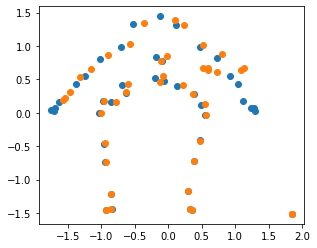

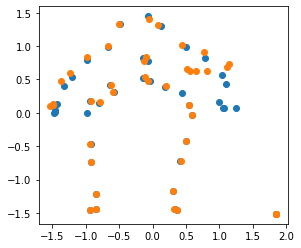

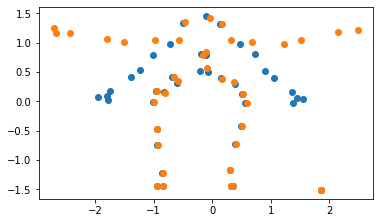

In [113]:
############ Test The Dataloader ######################

## This code is for case in which the sample is NOT flattened
'''i = 3
for sample,_ in train_dataloader:
  if i == 0:
    break
  i = i - 1
  frame = 1
  xs, ys, zs = sample[0, frame, :], sample[1, frame, :], sample[2, frame, :]
  plt.figure()
  plt.scatter(xs, zs)
  plt.axis('scaled')
  xs, ys, zs = sample[0, frame+10, :], sample[1, frame+10, :], sample[2, frame+10, :]
  plt.scatter(xs, zs)
  plt.axis('scaled')'''

## This code is for the case in which the sample IS flattened
i = 3
for sample,_ in train_dataloader:
  if i == 0:
    break
  i = i - 1
  frame = 1
  xs, ys, zs = sample[0, frame, 0:43], sample[0, frame, 43:86], sample[0, frame, 86:]
  plt.figure()
  plt.scatter(xs, zs)
  plt.axis('scaled')
  xs, ys, zs = sample[0, frame+10, 0:43], sample[0, frame+10, 43:86], sample[0, frame+10, 86:]
  plt.scatter(xs, zs)
  plt.axis('scaled')

In [29]:
class skeletonLSTM(nn.Module):
    def __init__(self, classes):
        super(skeletonLSTM, self).__init__()
        self.n_hidden = 100
        self.n_layers = 2
        self.l_lstm = torch.nn.LSTM(input_size = 129, 
                                 hidden_size = self.n_hidden,
                                 num_layers = self.n_layers, 
                                 batch_first = True)
        self.fc1 = nn.Linear(100, 50)
        self.fc2 = nn.Linear(50, classes)
        self.relu = nn.ReLU()
    def forward(self, x):
        #intialize lstm hidden state
        hidden_state = torch.zeros(self.n_layers, 1, self.n_hidden).cuda()
        cell_state = torch.zeros(self.n_layers, 1, self.n_hidden).cuda()
        self.hidden = (hidden_state, cell_state)      
        #print(x.shape)
        hidden_states, _ = self.l_lstm(x, self.hidden) #lstm_out shape is batch_size, seq len, hidden state
        hidden_states.retain_grad()
        lstm_out = hidden_states[:,-1,:] #last hidden state fed to FC layer
        lstm_out = self.relu(self.fc1(lstm_out.squeeze()))
        lstm_out = self.fc2(lstm_out)
        return lstm_out, hidden_states
    

In [12]:
 num_epochs = 50
 num_classes = 11
 model = skeletonLSTM(num_classes)
 model.cuda()
 loss_func = nn.CrossEntropyLoss()
 optimizer = torch.optim.Adam(model.parameters())
 
 train_loss_vec = []
 val_loss_vec = []
 for epoch in range(num_epochs):
    train_loss_for_epoch = []
    val_loss_for_epoch = []
    ########################### Training #####################################
    print("\nEPOCH " +str(epoch+1)+" of "+str(num_epochs)+"\n")
    for inputs, labels in train_dataloader:
          inputs = inputs.cuda()
          model.train()
          if labels not in tuple(range(num_classes)): #FUCK T-POSE
              continue
          labels = torch.Tensor([labels]).cuda()
          predictions = model(inputs)[0].unsqueeze(0)
          loss = loss_func(predictions, labels.long())
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          train_loss_for_epoch.append(loss.item())

    train_loss_vec.append(sum(train_loss_for_epoch) / len(train_loss_for_epoch))
    for inputs, labels in val_dataloader:
          inputs = inputs.cuda()
          model.eval()
          if labels not in tuple(range(num_classes)): #FUCK T-POSE
              continue
          labels = torch.Tensor([labels]).cuda()
          predictions = model(inputs)[0].unsqueeze(0)
          loss = loss_func(predictions, labels.long())
          val_loss_for_epoch.append(loss.item())
          if val_loss_for_epoch[-1] == min(val_loss_for_epoch):
              torch.save(model, '/content/gdrive/MyDrive/best_model.pth')
    val_loss_vec.append(sum(val_loss_for_epoch) / len(val_loss_for_epoch) )
    print("The training loss for Epoch " + str(epoch + 1) + " is " + str(train_loss_vec[-1]))
    print("The validation loss for Epoch " + str(epoch + 1) + " is " + str(val_loss_vec[-1]))



EPOCH 1 of 50

The training loss for Epoch 1 is 2.309800862451349
The validation loss for Epoch 1 is 2.28839619809931

EPOCH 2 of 50

The training loss for Epoch 2 is 1.9100416949525867
The validation loss for Epoch 2 is 1.7519705705302344

EPOCH 3 of 50

The training loss for Epoch 3 is 1.7389148240908316
The validation loss for Epoch 3 is 1.9497096446565014

EPOCH 4 of 50

The training loss for Epoch 4 is 1.6857038435344807
The validation loss for Epoch 4 is 1.5227152414111929

EPOCH 5 of 50

The training loss for Epoch 5 is 1.5090053874462224
The validation loss for Epoch 5 is 1.349655180296924

EPOCH 6 of 50

The training loss for Epoch 6 is 1.348473249831126
The validation loss for Epoch 6 is 1.1106301456224172

EPOCH 7 of 50

The training loss for Epoch 7 is 1.2265251805916468
The validation loss for Epoch 7 is 1.057056050493636

EPOCH 8 of 50

The training loss for Epoch 8 is 1.0751636039035009
The validation loss for Epoch 8 is 0.8451625618131154

EPOCH 9 of 50

The training l

In [14]:
def train_val_test(model, num_classes=11):
    for dataloader in [train_dataloader, val_dataloader, test_dataloader]:
        accurates = 0
        samples = 0 
        for input, label in dataloader:
            if label not in tuple(range(num_classes)): #FUCK T-POSE
                continue
            input = input.cuda()
            out = model(input)[0]
            if torch.argmax(out).item() == label:
              accurates += 1
            samples += 1
        accuracy = accurates / samples
        print(f'The model accuracy on the dataset is ' + str(accuracy))

model = torch.load('/content/gdrive/MyDrive/best_model.pth')
# 45ish epoch model https://drive.google.com/file/d/1SzOCnZ5kWuuEQ5GpYz9TAqYbjwYfP5kZ/view?usp=sharing
    ################ Model Accuracy On Train Dataset Post Training #################
train_val_test(model)    

The model accuracy on the dataset is 0.9931662870159453
The model accuracy on the dataset is 0.9454545454545454
The model accuracy on the dataset is 0.7757575757575758


(Text(0.5, 0, 'Epochs'), Text(0, 0.5, 'Cross Entropy Loss'))

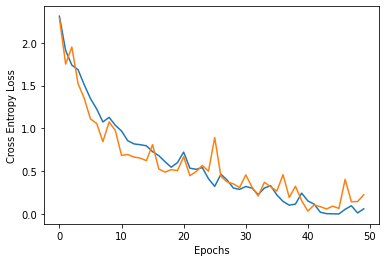

In [15]:
plt.plot(train_loss_vec)
plt.plot(val_loss_vec)
plt.xlabel('Epochs'), plt.ylabel('Cross Entropy Loss')

In [271]:
class GradientAttack():
        
        """
        
        """
        
        def __init__(self, loss, epsilon):
            """
            
            """
            self.loss = loss
            self.epsilon = epsilon

        def forward(self, x, y, model, num_iter=1, alpha=0.01, fix_rng=False):
            """
            Generates an adversary using the gradient sign method
            given an input feature, its associated label, and the model
            x: feature vector
            y: label associated with the feature vector
            model: the model used to classify x
            num_iter: number of iterations to perturb sample, for num_iter=1, uses fast gradient sign method
            alpha: the size of the perturbation for iterative gradient sign method         
            """
            y = torch.Tensor([y]).cuda()
            x = x.cuda()
            model.train()
            if num_iter > 1:
                if fix_rng == True:
                    torch.manual_seed(0)
                delta = torch.rand(x.shape, device='cuda')
                delta = delta * 2 * self.epsilon - self.epsilon
            else:            
                delta = torch.zeros(x.shape, device='cuda')
            x_adv = x.clone().detach()
            x_adv = x_adv + delta
            for iteration in range(num_iter):
                # Step 1: Calculate the Loss and then calculate the
                # gradient of the Loss w.r.t the image
                x_adv = x_adv.cuda()
                x_adv = Variable(x_adv, requires_grad=True)
                out = model(x_adv)
                loss_adv = self.loss(out[0].unsqueeze(0), y.long())
                loss_adv.backward(retain_graph=True) 
                grad = x_adv.grad
                with torch.no_grad():
                    # Step 2: Add the gradient (or its sign for each pixel),
                    # multiplied by a small step size, to the original image                      
                    if num_iter > 1:                                                           
                        x_temp = x_adv + torch.sign(x_adv.grad) * alpha
                        # Clamp the attack to be within such that the maximum difference is epsilon
                        delta = torch.clamp(x_temp - x, -self.epsilon, self.epsilon)
                        x_adv = x + delta
                    else:
                        x_adv = x + torch.sign(grad) * self.epsilon
            
            return x_adv

class HAttack():
        
        """
        
        """
        
        def __init__(self, loss, epsilon):
            """
            
            """
            self.loss = loss
            self.epsilon = epsilon

        def forward(self, x, y, model, num_iter=1, pmp_iter=1, alpha=0.01, fix_rng=False):
            """
            Implementation for PGD Attack
            """ 
            # Move data to GPU      
            y = torch.Tensor([y]).cuda()
            x = x.cuda()
                      
            if fix_rng == True:
                torch.manual_seed(0)
            # Initialize random perturbation
            delta = torch.rand(x.shape, device='cuda', requires_grad=True)
            delta = delta * 2 * self.epsilon - self.epsilon
            for iteration in range(num_iter):
                # Forward Pass
                out = model(x + delta)
                loss_adv = self.loss(out[0].unsqueeze(0), y.long())
                # Backwards Pass    
                loss_adv.backward(retain_graph=True) 
                hidden_states = out[1]
                p = hidden_states.grad[0].clone().detach() # p-vectors are just the gradients of each hidden state w.r.t CE loss
                objectives = torch.sum(torch.mul(p, hidden_states.squeeze()), axis=1).cuda() 
                for i in range(pmp_iter):
                    if i != 0: #because we already compute it 
                        out = model(x + delta)
                        hidden_states = out[1] # We technically don't need to compute FC layers here
                        objectives = torch.sum(torch.mul(p, hidden_states.squeeze()), axis=1).cuda() # Dot-product of p with its next hidden state forms objective
                    grad = torch.autograd.grad(objectives, delta, torch.ones(x.shape[1]).cuda())[0] # Use gradient descent to figure out update direction
                    delta = delta + alpha * torch.sign(grad) # Update our perturbation
                    delta = torch.clamp(delta, -self.epsilon, self.epsilon) # Project into Adversarial Space
            x_adv = x + delta
            return x_adv

In [ ]:
losses_pmp = []
accs_pmp = []
times_pmp = []

for iteration in iteration_range:
    loss_pgd_ = 0
    acc_pgd_ = 0
    time_pgd_ = 0
    for input, label in test_dataloader:
        torch.cuda.empty_cache()

        if label == 11:
            continue
        label_eval = torch.Tensor([label]).cuda().long()

        if pmp_iteration == 1: # Compare against PGD
            fixed_rng = True
            t_s = time.time()
            adv_pgd = pgd_attack.forward(input, label, model, num_iter=iteration, fix_rng=fixed_rng)
            t_f = time.time()
            out_pgd = model(adv_pgd)[0].unsqueeze(0)
            loss_pgd_ += loss(out_pgd, label_eval).item()
            if torch.argmax(out_pgd).item() == label:
                acc_pgd_ += 1
            time_pgd_ += t_f - t_s


In [279]:
pgd_attack = GradientAttack(loss, 0.1)
pmp_attack = HAttack(loss, 0.1)
iteration_range = np.arange(2, 51, 2)
pmp_iteration_range = np.arange(1, 6, 1)

loss_pgd = []
acc_pgd = []
time_pgd = []

losses_pmp = []
accs_pmp = []
times_pmp = []

loss = nn.CrossEntropyLoss()

for pmp_iteration in pmp_iteration_range:
    print(f'Inner Iterations used for PMP: {pmp_iteration}')
    loss_pmp = []
    acc_pmp = []
    time_pmp = []
    for iteration in iteration_range:
        loss_pgd_ = 0
        acc_pgd_ = 0
        time_pgd_ = 0
        loss_pmp_ = 0
        acc_pmp_ = 0
        time_pmp_ = 0
        fixed_rng = False
        for input, label in test_dataloader:
            torch.cuda.empty_cache()

            if label == 11:
                continue
            label_eval = torch.Tensor([label]).cuda().long()

            if pmp_iteration == 1: # Compare against PGD
                fixed_rng = True
                t_s = time.time()
                adv_pgd = pgd_attack.forward(input, label, model, num_iter=iteration, fix_rng=fixed_rng)
                t_f = time.time()
                out_pgd = model(adv_pgd)[0].unsqueeze(0)
                loss_pgd_ += loss(out_pgd, label_eval).item()
                if torch.argmax(out_pgd).item() == label:
                    acc_pgd_ += 1
                time_pgd_ += t_f - t_s

            t_s = time.time()   
            adv_pmp = pmp_attack.forward(input, label, model, num_iter=iteration, pmp_iter=pmp_iteration, fix_rng=fixed_rng)
            t_f = time.time()
            out_pmp = model(adv_pmp)[0].unsqueeze(0)
            loss_pmp_ += loss(out_pmp, label_eval).item()
            if torch.argmax(out_pmp).item() == label:
                acc_pmp_ += 1
            time_pmp_ += t_f - t_s

        loss_pmp.append(loss_pmp_ / len(test_dataloader))
        acc_pmp.append(acc_pmp_ / len(test_dataloader))
        time_pmp.append(time_pmp_ / len(test_dataloader))
        if pmp_iteration == 1:
            loss_pgd.append(loss_pgd_ / len(test_dataloader))
            acc_pgd.append(acc_pgd_ / len(test_dataloader))
            time_pgd.append(time_pgd_ / len(test_dataloader))
            print(loss_pgd[-1], acc_pgd[-1], time_pgd[-1], loss_pmp[-1], acc_pmp[-1], time_pmp[-1])
        else:
            print(loss_pmp[-1], acc_pmp[-1], time_pmp[-1])
    losses_pmp.append(loss_pmp)
    accs_pmp.append(acc_pmp)
    times_pmp.append(time_pmp)


#save the arrays
losses_pmp = np.asarray(losses_pmp)
accs_pmp = np.asarray(accs_pmp)
times_pmp = np.asarray(times_pmp)
loss_pgd = np.asarray(loss_pgd)
acc_pgd = np.asarray(acc_pgd)
time_pgd = np.asarray(time_pgd)
np.save('/content/gdrive/MyDrive/losses_pmp.npy', losses_pmp)
np.save('/content/gdrive/MyDrive/accs_pmp.npy', accs_pmp)
np.save('/content/gdrive/MyDrive/times_pmp.npy', times_pmp)
np.save('/content/gdrive/MyDrive/loss_pgd.npy', loss_pgd)
np.save('/content/gdrive/MyDrive/acc_pgd.npy', acc_pgd)
np.save('/content/gdrive/MyDrive/time_pgd.npy', time_pgd)


Inner Iterations used for PMP: 1
2.1584253360990378 0.6964285714285714 0.016375157095137097 2.158425678143884 0.6964285714285714 0.025272332486652192
2.563266687001876 0.6607142857142857 0.03327500394412449 2.5632670965177162 0.6607142857142857 0.05133020452090672
2.81413105380172 0.6309523809523809 0.05021651302065168 2.814130679476568 0.6309523809523809 0.07747584013711839
3.194329664220716 0.5833333333333334 0.06648448393458412 3.1943404160349425 0.5833333333333334 0.10329490758123852
3.440158024626194 0.5595238095238095 0.08345376735641843 3.4401482907309107 0.5595238095238095 0.12928473807516552
3.6257320209224893 0.5297619047619048 0.1006392552739098 3.6257306415339716 0.5297619047619048 0.15597667154811679
3.8339668738060633 0.5 0.11731828252474467 3.833968613549894 0.5 0.18236359244301206
3.954184185779557 0.5059523809523809 0.1340227723121643 3.9594436816733167 0.5059523809523809 0.20883721397036598
4.096835811617792 0.48214285714285715 0.15042509777205332 4.098040276424125 0.

In [6]:
#load saved arrays
losses_pmp = np.load('/content/gdrive/MyDrive/losses_pmp.npy')
accs_pmp = np.load('/content/gdrive/MyDrive/accs_pmp.npy')
times_pmp = np.load('/content/gdrive/MyDrive/times_pmp.npy')
loss_pgd = np.load('/content/gdrive/MyDrive/loss_pgd.npy')
accs_pgd = np.load('/content/gdrive/MyDrive/acc_pgd.npy')
time_pgd = np.load('/content/gdrive/MyDrive/time_pgd.npy')

Text(0, 0.5, 'CE Loss')

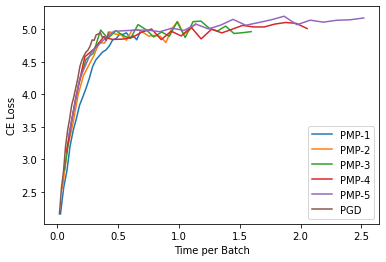

In [16]:
for i in range(5):
  plt.plot(times_pmp[i, :], losses_pmp[i, :])

plt.plot(time_pgd, loss_pgd)
plt.legend(['PMP-1', 'PMP-2', 'PMP-3', 'PMP-4', 'PMP-5', 'PGD' ])
plt.xlabel('Time per Batch')
plt.ylabel('CE Loss')

Text(0, 0.5, 'CE Loss')

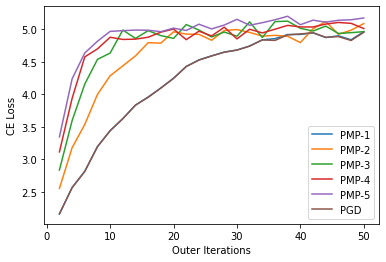

In [18]:
iterations = np.arange(2, 51, 2)
for i in range(5):
  plt.plot(iterations, losses_pmp[i, :])

plt.plot(iterations, loss_pgd)
plt.legend(['PMP-1', 'PMP-2', 'PMP-3', 'PMP-4', 'PMP-5', 'PGD' ])
plt.xlabel('Outer Iterations')
plt.ylabel('CE Loss')

Text(0, 0.5, 'CE Loss')

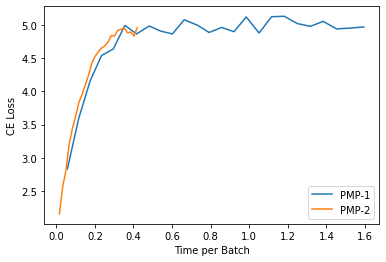

In [21]:
plt.plot(times_pmp[2, :], losses_pmp[2, :])

plt.plot(time_pgd, loss_pgd)
plt.legend(['PMP-1', 'PMP-2', 'PMP-3', 'PMP-4', 'PMP-5', 'PGD' ])
plt.xlabel('Time per Batch')
plt.ylabel('CE Loss')

In [ ]:
loss = nn.CrossEntropyLoss()
adv_attack = GradientAttack(loss, 0.1)
loss1 = []
accs1 = []
for iteration in iteration_range:
        losses = 0
        acc1 = 0
        for input, label in test_dataloader:
            if label == 11:
                continue
            torch.cuda.empty_cache()   
            input_adv = adv_attack.forward(input, label, model, num_iter=iteration)


            model.eval()
            out = model(input_adv)[0].unsqueeze(0)
            label = torch.Tensor([label]).cuda().long()
            losses += loss(out, label).item() 
            if torch.argmax(out).item() == label:
                acc1 += 1
        loss1.append(losses / len(test_dataloader))
        accs1.append(acc1 / len(test_dataloader))
        print(loss1[-1], accs1[-1])

In [186]:

loss = nn.CrossEntropyLoss()
adv_attack = GradientAttack(loss, 0.1)

################ Model Accuracy On Train Dataset Against Attacks#################
accurates = 0
for input, label in train_dataloader:
    if label == 11: 
        continue
    input_adv = adv_attack.forward(input, label, model, num_iter=1)
    model.eval()
    out = model(input_adv)[0]
    if torch.argmax(out).item() == label:
        accurates += 1

accuracy = accurates / len(train_dataloader)
print('The model accuracy on the train dataset after training is ' + str(accuracy))

################ Model Accuracy On Validation Dataset Against Attacks #################
accurates = 0
for input, label in val_dataloader:
    if label == 11: 
        continue
    input_adv = adv_attack.forward(input, label, model, num_iter=1)
    model.eval()
    out = model(input_adv)[0]
    if torch.argmax(out).item() == label:
        accurates += 1

accuracy = accurates / len(val_dataloader)
print('The model accuracy on the validation dataset after training is ' + str(accuracy))

################ Model Accuracy On Test Dataset Against Attacks#################    
accurates = 0
for input, label in test_dataloader:
    if label == 11: 
        continue
    input_adv = adv_attack.forward(input, label, model, num_iter=1)
    model.eval()
    out = model(input_adv)[0]
    if torch.argmax(out).item() == label:
        accurates += 1

accuracy = accurates / len(test_dataloader)
print('The model accuracy on the testing dataset after training is ' + str(accuracy))

None


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations.


TypeError: ignored

In [22]:
loss = nn.CrossEntropyLoss()
adv_attack = GradientAttack(loss, 0.1)

################ Model Accuracy On Train Dataset Against Attacks#################
accurates = 0
for input, label in train_dataloader:
    if label == 11: 
      continue
    input_adv = adv_attack.forward(input, label, model, num_iter=100, alpha=0.005)
    model.eval()
    out = model(input_adv)[0]
    if torch.argmax(out).item() == label:
      accurates += 1

accuracy = accurates / len(train_dataloader)
print('The model accuracy on the train dataset after training is ' + str(accuracy))

################ Model Accuracy On Validation Dataset Against Attacks#################
accurates = 0
for input, label in val_dataloader:
    if label == 11: 
          continue
    input_adv = adv_attack.forward(input, label, model, num_iter=100, alpha=0.005)
    model.eval()
    out = model(input_adv)[0]
    if torch.argmax(out).item() == label:
      accurates += 1

accuracy = accurates / len(val_dataloader)
print('The model accuracy on the validation dataset after training is ' + str(accuracy))


################ Model Accuracy On Test Dataset Against Attacks#################
accurates = 0
for input, label in test_dataloader:
    if label == 11: 
          continue
    input_adv = adv_attack.forward(input, label, model, num_iter=100, alpha=0.005)
    model.eval()
    out = model(input_adv)[0]
    if torch.argmax(out).item() == label:
      accurates += 1

accuracy = accurates / len(test_dataloader)
print('The model accuracy on the testing dataset after training is ' + str(accuracy))

The model accuracy on the train dataset after training is 0.6129753914988815
The model accuracy on the validation dataset after training is 0.5714285714285714
The model accuracy on the testing dataset after training is 0.4107142857142857


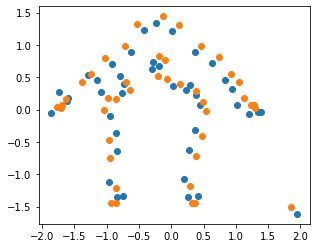

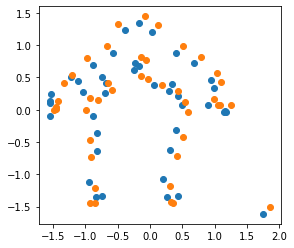

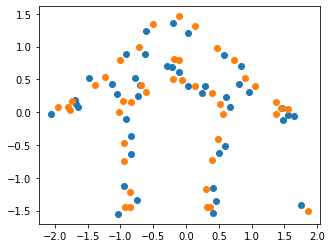

In [23]:
## This code is for the case in which the sample IS flattened
i = 3
for input, label in train_dataloader:
  if label == 11: 
      continue
  orig_input = input
  sample = adv_attack.forward(input, label, model, num_iter=200, alpha=0.0025).cpu().detach()
  if i == 0:
    break
  i = i - 1
  frame = 1
  xs, ys, zs = sample[0, frame, 0:43], sample[0, frame, 43:86], sample[0, frame, 86:]
  plt.figure()
  plt.scatter(xs, zs)
  plt.axis('scaled')
  xs, ys, zs = orig_input[0, frame, 0:43], orig_input[0, frame, 43:86], orig_input[0, frame, 86:]
  plt.scatter(xs, zs)
  plt.axis('scaled')

Probably should use 20 or so epochs based on these results